In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
df = df[['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']]

# Transform names using the next line:
#   ```
#   data.columns = data.columns.str.replace(' ', '_').str.lower()
#   ```
# * Fill in the missing values of the selected features with 0.
# * Rename `MSRP` variable to `price`.

df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df = df.rename(columns={'msrp': 'price'})

# Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

df['above_average'] = (df['price'] > df['price'].mean()).astype(int)
df = df.drop(columns=['price'])

In [28]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use `train_test_split` function for that with `random_state=1`

X = df.drop(columns=['above_average'])
y = df['above_average']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [29]:
### Question 1: ROC AUC feature importance

# - `engine_hp`

from sklearn.metrics import roc_auc_score

numerical = X_train.select_dtypes(include=[np.number]).columns

for col in numerical:
    auc = roc_auc_score(y_train, X_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])
    print(col, auc)

year 0.6943018002799936
engine_hp 0.9159001518508375
engine_cylinders 0.768274900593613
highway_mpg 0.6333685399678282
city_mpg 0.67232674562278


In [30]:

### Question 2: Training the model

# - 0.979

from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1].round(3)
auc = roc_auc_score(y_val, y_pred)
print(round(auc, 3))

0.977


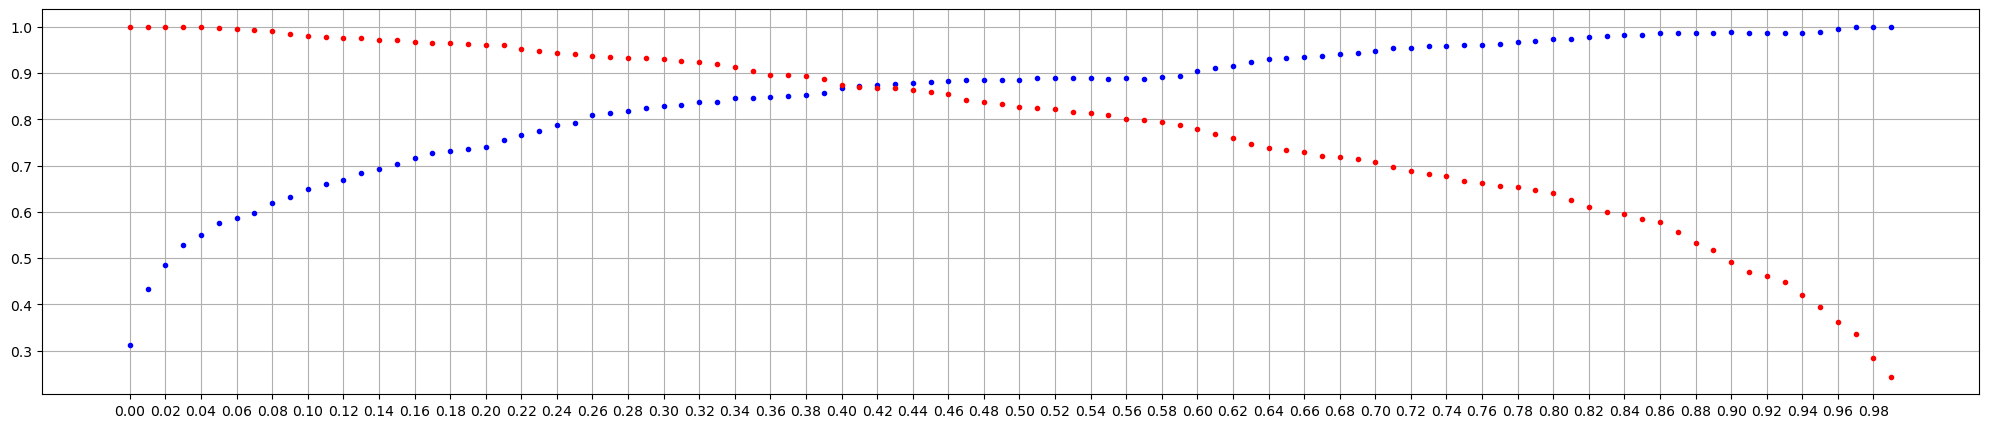

In [37]:
### Question 3: Precision and Recall

# * 0.48


from sklearn.metrics import precision_score, recall_score


plt.figure(figsize=(25, 5))

for step in range(0, 100):
    threshold = step / 100
    y_pred_t = (y_pred > threshold).astype(int)
    precision = precision_score(y_val, y_pred_t)
    recall = recall_score(y_val, y_pred_t)

    plt.plot(threshold, precision, 'b.')
    plt.plot(threshold, recall, 'r.')
    plt.xticks(np.arange(0, 1, 0.02))
    plt.grid(True)

In [40]:
### Question 4: F1 score

# - 0.32


def f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall)

max_f1 = 0
best_threshold = 0

for step in range(0, 100):
    threshold = step / 100
    y_pred_t = (y_pred > threshold).astype(int)
    precision = precision_score(y_val, y_pred_t)
    recall = recall_score(y_val, y_pred_t)
    f1 = f1_score(precision, recall)
    
    if f1 > max_f1:
        max_f1 = f1
        best_threshold = threshold
        
print('Threshold', round(best_threshold, 2), 'F1', round(max_f1, 2))

Threshold 0.34 F1 0.88


In [46]:
### Question 6: Hyperparemeter Tuning

# - 10

# If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

C = [0.01, 0.1, 0.5, 10]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)


scores = {str(C_): [] for C_ in C}

for xtrain_idx, xval_idx in kfold.split(X_full_train):
    xtrain, xval = X_full_train.iloc[xtrain_idx], X_full_train.iloc[xval_idx]
    ytrain, yval = y_full_train.iloc[xtrain_idx], y_full_train.iloc[xval_idx]
    
    dv = DictVectorizer(sparse=False)

    train_dict = xtrain.to_dict(orient='records')
    xtrain = dv.fit_transform(train_dict)
    
    val_dict = xval.to_dict(orient='records')
    xval = dv.transform(val_dict)
    
    for C_ in C:
        model = LogisticRegression(solver='liblinear', C=C_, max_iter=1000)
        model.fit(xtrain, ytrain)
        
        y_pred = model.predict_proba(xval)[:, 1]
        auc = roc_auc_score(yval, y_pred)
        scores[str(C_)].append(auc)

for C_ in C:
    print(C_, np.round(np.mean(scores[str(C_)]),3), np.round(np.std(scores[str(C_)]), 3))
    

0.01 0.952 0.002
0.1 0.972 0.002
0.5 0.977 0.002
10 0.981 0.002
